This notebook produces some extra graphs used for private correspondance. 

In [1]:
import numpy as np
import pymc3 as pm
import pickle
import copy

from tqdm import tqdm

from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.pymc3_models.base_model import produce_CIs, add_cms_to_plot

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Set Theano Environmental Variables for Parallelisation


In [2]:
full_trace = pickle.load(open('traces/final_full.pkl', 'rb'))

AttributeError: Can't get attribute '_latex_repr_rv' on <module 'pymc3.model' from '/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.8/lib/python3.8/site-packages/pymc3/model.py'>

In [ ]:
data = preprocess_data('../merged_data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

In [ ]:
from scipy.stats import nbinom
from scipy.signal import convolve

In [ ]:
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]


In [ ]:
def simulate_model(rg, full_trace, CM_Alpha, RegionR, growth_cases_noise, growth_deaths_noise, InitialSizeCases, InitialSizeDeaths):
    r_i = data.Rs.index(f'{rg}')

    nS, nCMs = CM_Alpha.shape
    nDs = len(data.Ds)

    ActiveCMRed = np.sum(data.ActiveCMs[r_i, :, : ].reshape((1, nCMs, nDs)) * CM_Alpha.reshape((nS, nCMs, 1)), axis=1)    
    log_r = np.log(RegionR.reshape((nS, 1))) - ActiveCMRed
    gi_beta = full_trace['GI_mean'] / full_trace['GI_sd'] ** 2
    gi_alpha = full_trace['GI_mean'] ** 2 /full_trace['GI_sd'] ** 2

    PsiCases = full_trace['PsiCases']
    PsiDeaths = full_trace['PsiDeaths']

    ExpectedGrowth = gi_beta.reshape((nS, 1)) * (np.exp(log_r / gi_alpha.reshape((nS, 1))) - np.ones_like(log_r))

    growth_cases = copy.deepcopy(ExpectedGrowth)
    growth_deaths = copy.deepcopy(ExpectedGrowth)

    growth_cases[:, 30:-10] += growth_cases_noise
    growth_deaths[:, 30:-10] += growth_deaths_noise

    infected_cases = np.exp(InitialSizeCases + np.cumsum(growth_cases, axis=-1))
    infected_deaths = np.exp(InitialSizeDeaths + np.cumsum(growth_deaths, axis=-1))

    cases_means = full_trace['CasesDelayMean']
    deaths_means = full_trace['DeathsDelayMean']
    cases_disps = full_trace['CasesDelayDisp']
    deaths_disps = full_trace['DeathsDelayDisp']

    expected_cases = np.zeros((nS, nDs))
    expected_deaths = np.zeros((nS, nDs))

    def discrete_nb_distribution(mean, disp, trunc):
        p = disp / (disp + mean)
        bins = np.arange(0, trunc)
        pmf = nbinom.pmf(bins, disp, p)
        pmf = pmf / np.sum(pmf)
        return pmf

    for i in range(nS):
        cases_delay = discrete_nb_distribution(cases_means[i], cases_disps[i], 32)
        deaths_delay = discrete_nb_distribution(deaths_means[i], deaths_disps[i], 48)
        expected_cases[i, :] = convolve(infected_cases[i, :], cases_delay, mode='full')[:nDs]
        expected_deaths[i, :] = convolve(infected_deaths[i, :], deaths_delay, mode='full')[:nDs]

    output_cases = np.zeros((nS, nDs))
    output_deaths = np.zeros((nS, nDs))
    for i in range(nS):
        mean_cases = expected_cases[i, :]
        p_cases = PsiCases[i] / (PsiCases[i] + mean_cases)
        cases = nbinom.rvs(PsiCases[i], p_cases)
        output_cases[i, :] = cases

        mean_deaths = expected_deaths[i, :]
        p_deaths = PsiDeaths[i] / (PsiDeaths[i] + mean_deaths)
        deaths = nbinom.rvs(PsiDeaths[i], p_deaths)
        output_deaths[i, :] = deaths
        
    return output_deaths, output_cases

In [19]:
def epicurve_plot(output_cases, output_deaths, data, title, r_i, extra_unmask_all=False):
    data.unmask_all()
    data.mask_reopenings(print_out = False)
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]
    else:
        end_d_i = len(data.Ds)
    
    if not extra_unmask_all:
        data.mask_region(data.Rs[r_i])
    start_d_i = 30
    
    means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(
       output_deaths
    )

    means_expected_cases, lu_ec, up_ec, _, _= produce_CIs(
        output_cases
    )
    
    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()

    plt.plot(
        days_x,
        means_expected_deaths,
        label="Predicted Daily Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        days_x,
        deaths,
        label="Recorded Daily Deaths",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        deaths.data,
        label="Heldout Daily Deaths (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:red",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )
    
    plt.plot(
        days_x,
        means_expected_cases,
        label="Predicted Daily Confirmed Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        days_x,
        cases,
        label="Recorded Daily Confirmed Cases",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        cases.data,
        label="Heldout Daily Confirmed Cases",
        marker="o",
        s=12,
        edgecolor="tab:blue",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )

    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(title, fontsize=12)

In [ ]:
class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]
        self.PsiCases = trace.PsiCases
        self.PsiDeaths = trace.PsiDeaths
        self.InitialSizeCases_log = trace.InitialSizeCases_log[:, indx]
        self.InitialSizeDeaths_log = trace.InitialSizeDeaths_log[:, indx]
        self.GrowthCasesNoise = trace.GrowthCasesNoise[:, indx, :]
        self.GrowthDeathsNoise = trace.GrowthDeathsNoise[:, indx, :]

In [ ]:
full_trace.varnames

In [ ]:
regions = data.Rs
fig_index = 0

for row, rg in tqdm(enumerate(regions)):
    if row % 5 == 0:
        plt.figure(figsize=(12, 15), dpi=300)
    
    R_name = data.RNames[rg][0]
    r_i = data.Rs.index(rg)
    
    full_CM_Alpha = full_trace.CM_Alpha
    holdout_trace = pickle.load(open(f"../../server/sensitivity_default_updated/region_holdout/{rg}.pkl", "rb"))
    holdout_CM_Alpha = -np.log(holdout_trace.CMReduction)
    
    plt.subplot(5, 4, 4*(row%5) + 1)
    
    output_deaths, output_cases = simulate_model(rg, full_trace, holdout_CM_Alpha, holdout_trace.RegionR, holdout_trace.GrowthCasesNoise, holdout_trace.GrowthDeathsNoise, holdout_trace.InitialSizeCases_log, holdout_trace.InitialSizeDeaths_log)
    epicurve_plot(output_cases, output_deaths, data, f'{R_name}\nHoldout', r_i)
   
    plt.subplot(5, 4, 4*(row%5) + 2)
    output_deaths, output_cases = simulate_model(rg, full_trace, full_trace.CM_Alpha, holdout_trace.RegionR, holdout_trace.GrowthCasesNoise, holdout_trace.GrowthDeathsNoise, holdout_trace.InitialSizeCases_log, holdout_trace.InitialSizeDeaths_log)
    epicurve_plot(output_cases, output_deaths, data, f'{R_name}\nHoldout + Full $\\{{\\alpha_i\\}}$', r_i)
   
    plt.subplot(5, 4, 4*(row%5) + 3)
    output_deaths, output_cases = simulate_model(rg, full_trace, full_trace.CM_Alpha, full_trace.RegionR[:, r_i], holdout_trace.GrowthCasesNoise, holdout_trace.GrowthDeathsNoise, full_trace.InitialSizeCases_log[:, r_i], full_trace.InitialSizeDeaths_log[:, r_i])
    epicurve_plot(output_cases, output_deaths, data, f'{R_name}\nHoldout + Full $\\{{\\alpha_i\\}}, R_0, N_{{0,c}}$', r_i)

    plt.subplot(5, 4, 4*(row%5) + 4)
    output_deaths, output_cases = simulate_model(rg, full_trace, full_trace.CM_Alpha, full_trace.RegionR[:, r_i], full_trace.GrowthCasesNoise[:, r_i, :], full_trace.GrowthDeathsNoise[:, r_i, :], full_trace.InitialSizeCases_log[:, r_i], full_trace.InitialSizeDeaths_log[:, r_i])
    epicurve_plot(output_cases, output_deaths, data, f'{R_name}\nModel Fit', r_i, extra_unmask_all=True)
    
    if row % 5 == 4 or row == len(regions) - 1:
        plt.tight_layout()
        plt.savefig(f'figs/rebuttal/FigOverfit{int(fig_index)}.pdf', bbox_inches='tight')
        fig_index += 1

# infection counts

In [ ]:
regions = ['FR', 'DE', 'SE', 'CH']

In [ ]:
def infections_plot(trace, data, title, r_i):
    data.unmask_all()
    data.mask_reopenings(print_out = False)
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]
    else:
        end_d_i = len(data.Ds)
    
    start_d_i = 30
    
    means_expected_deaths_infected, lu_edi, up_edi, _, _ = produce_CIs(
       trace.InfectedDeaths[:, r_i, :]
    )

    means_expected_cases_infected, lu_eci, up_eci, _, _= produce_CIs(
        trace.InfectedCases[:, r_i, :]
    )
    
    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()

    plt.plot(
        days_x,
        means_expected_deaths_infected,
        label="Daily Infections -\n Later Deaths",
        zorder=2,
        color="tab:orange"
    )

    plt.fill_between(
        days_x, lu_edi, up_edi, alpha=0.25, color="tab:orange", linewidth=0
    )

    plt.plot(
        days_x,
        means_expected_cases_infected,
        label="Daily Infections -\n Later Confirmed",
        zorder=2,
        color="tab:purple"
    )

    plt.fill_between(
        days_x, lu_eci, up_eci, alpha=0.25, color="tab:purple", linewidth=0
    )
    
    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(title, fontsize=12)
    return ax 

In [ ]:
plt.figure(figsize=(7, 7), dpi=300)
for row, rg in enumerate(regions):
    R_name = data.RNames[rg][0]
    r_i = data.Rs.index(rg)
    
    plt.subplot(2, 2, row+1)
    ax = infections_plot(full_trace, data, data.RNames[rg][0], r_i)
    
    if row == 0:
        ax.legend(shadow=True, fancybox=True, fontsize=8, loc='lower right')
    
plt.tight_layout()
plt.savefig('figs/rebuttal/infection_counts.pdf', bbox_inches='tight')

In [74]:
from scipy.stats import nbinom
from scipy.signal import convolve

CM_Alpha = np.array([1.6]).reshape((1, 1)).repeat(8000, axis=0)
nS, nCMs = CM_Alpha.shape

nDs = 100

ActiveCMs = np.zeros((nCMs, nDs))
ActiveCMs[0, 40:] = 1

ActiveCMRed = np.sum(ActiveCMs[:, :].reshape((1, nCMs, nDs)) * CM_Alpha.reshape((nS, nCMs, 1)), axis=1)    

log_r = np.log((3.5*np.ones(nS)).reshape((nS, 1))) - ActiveCMRed
gi_beta = (5.06*np.ones(nS)) / (np.ones(nS) * 2.11) ** 2
gi_alpha = (5.06*np.ones(nS)) ** 2 / (np.ones(nS) * 2.11) ** 2

PsiCases = 4*np.ones(nS)
PsiDeaths = 5*np.ones(nS)

ExpectedGrowth = gi_beta.reshape((nS, 1)) * (np.exp(log_r / gi_alpha.reshape((nS, 1))) - np.ones_like(log_r))

growth_cases = copy.deepcopy(ExpectedGrowth)
growth_deaths = copy.deepcopy(ExpectedGrowth)

growth_cases += 0.05*np.random.normal(size=growth_cases.shape)
growth_deaths += 0.05*np.random.normal(size=growth_cases.shape)

infected_cases = np.exp(0.5 + np.cumsum(growth_cases, axis=-1))
infected_deaths = np.exp(-4 + np.cumsum(growth_deaths, axis=-1))

cases_means = np.ones(nS) * 10.92
deaths_means = np.ones(nS) * 21.8
cases_disps = np.ones(nS) * 5.4
deaths_disps = np.ones(nS) * 14

expected_cases = np.zeros((nS, nDs))
expected_deaths = np.zeros((nS, nDs))

def discrete_nb_distribution(mean, disp, trunc):
    p = disp / (disp + mean)
    bins = np.arange(0, trunc)
    pmf = nbinom.pmf(bins, disp, p)
    pmf = pmf / np.sum(pmf)
    return pmf

for i in range(nS):
    cases_delay = discrete_nb_distribution(cases_means[i], cases_disps[i], 32)
    deaths_delay = discrete_nb_distribution(deaths_means[i], deaths_disps[i], 48)
    expected_cases[i, :] = convolve(infected_cases[i, :], cases_delay, mode='full')[:nDs]
    expected_deaths[i, :] = convolve(infected_deaths[i, :], deaths_delay, mode='full')[:nDs]

output_cases = np.zeros((nS, nDs))
output_deaths = np.zeros((nS, nDs))
for i in range(nS):
    mean_cases = expected_cases[i, :]
    p_cases = PsiCases[i] / (PsiCases[i] + mean_cases)
    cases = nbinom.rvs(PsiCases[i], p_cases)
    output_cases[i, :] = cases

    mean_deaths = expected_deaths[i, :]
    p_deaths = PsiDeaths[i] / (PsiDeaths[i] + mean_deaths)
    deaths = nbinom.rvs(PsiDeaths[i], p_deaths)
    output_deaths[i, :] = deaths

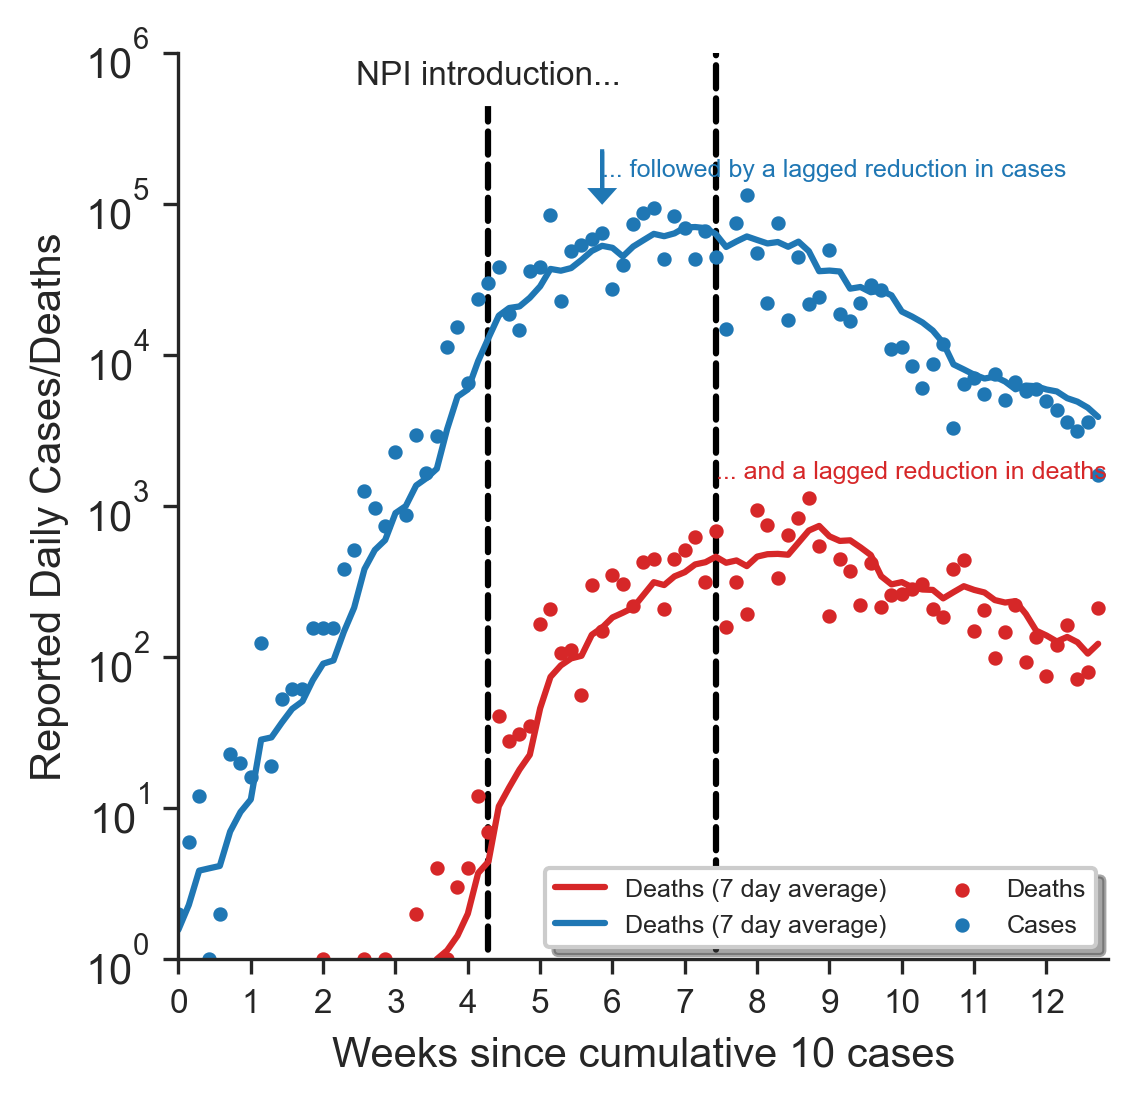

In [193]:
plt.figure(figsize=(4, 4), dpi=300)

deaths = output_deaths[10, :]
cases = output_cases[10, :]

cumulative_deaths = np.cumsum(deaths)
cumulative_cases = np.cumsum(cases)

deaths_ave = np.zeros_like(deaths)
cases_ave = np.zeros_like(cases)

deaths_ave[7:] = 1./7 * (cumulative_deaths[7:] - cumulative_deaths[:-7])
cases_ave[7:] = 1./7 * (cumulative_cases[7:] - cumulative_cases[:-7])


end_d_i = 100
start_d_i = np.nonzero(np.cumsum(cases)>10)[0][0]

means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(
   output_deaths
)

means_expected_cases, lu_ec, up_ec, _, _= produce_CIs(
    output_cases
)

days_x = np.arange(100)
ax = plt.gca()

plt.scatter(
    days_x,
    deaths,
    label="Deaths",
    marker="o",
    s=6,
    color="tab:red",
)


plt.scatter(
    days_x,
    cases,
    label="Cases",
    marker="o",
    s=6,
    color="tab:blue",
)

plt.plot(days_x, deaths_ave, color='tab:red', label='Deaths (7 day average)')
plt.plot(days_x, cases_ave, color='tab:blue', label='Deaths (7 day average)')


ax.set_yscale("log")
plt.ylim([10 ** 0, 10 ** 6])
locs = np.arange(start_d_i, end_d_i, 7)
plt.xlim((start_d_i, end_d_i))

plt.plot([40, 40], [10**7, 1], 'k--', zorder=-5, dash_capstyle='round')
plt.arrow(40+11, 10**5.35, 0, -10**5, color='tab:blue', head_length=20000, head_width=2)
# plt.plot([40+11, 40+11], [10**5.5, 1], '--', zorder=-5, color='tab:blue')
# plt.plot([40+22, 40+22], [10**5.5, 1], '--', zorder=-5, color='tab:red')

plt.text(40, 10**5.75, 'NPI introduction...', ha='center', va='bottom', backgroundcolor='white', size=8)
plt.text(51, 10**5.15, '... followed by a lagged reduction in cases', ha='left', va='bottom', size=6, color='tab:blue')

plt.text(62, 10**3.15, '... and a lagged reduction in deaths', ha='left', va='bottom', size=6, color='tab:red')
plt.ylim([1, 10**6])
# plt.ylim([1, 10**5.75])

plt.plot([62, 62], [10**7, 1], 'k--', zorder=-5, dash_capstyle='round')

plt.ylabel('Reported Daily Cases/Deaths', fontsize=10)
plt.xticks(np.arange(start_d_i, end_d_i, 7), np.arange(0, np.arange(start_d_i, end_d_i, 7).size), fontsize=8)
plt.xlabel('Weeks since cumulative 10 cases', fontsize=10)
plt.minorticks_off()
sns.despine()

plt.legend(loc='lower right', fontsize=6, fancybox=True, shadow=True, ncol=2)

plt.savefig('example.svg')